<a href="https://colab.research.google.com/github/johanhoffman/DD2363-VT20/blob/JonasNylund/Lab-3/jonasnylund_lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 3: Iterative Methods**
**Jonas Nylund**

# **Abstract**

#**About the code**

A short statement on who is the author of the file, and if the code is distributed under a certain license. 

In [90]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2019 Jonas Nylund (jonasnyl@kth.se)

# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

To have access to the neccessary modules you have to run this cell. If you need additional modules, this is where you add them. 

In [0]:
# Load neccessary modules.
from google.colab import files

import time
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import tri
from matplotlib import axes
from mpl_toolkits.mplot3d import Axes3D

import unittest

# **Introduction**

Iterative methods are useful for solving systems where exact solutions cannot be calculated directly, or when doing so might be too expensive. In this lab, we implement a few iterative methods for solving certain problems.


# **Methods**

**Richardson iteration**
We start by implementing Richardson iteration, which is the foundation for other, more refined iterative methods for solving systems of linear equations.

In [0]:
def richardsonIter(A,b,alpha, TOL = 10**(-8), max_iter=1000):
  r = np.random.rand(len(b));
  x = np.random.rand(len(b));
  i=0;
  while np.linalg.norm(r) > TOL:
    r = b-A@x;
    x += alpha*r;
    i+=1;
    if(i> max_iter):
      raise ArithmeticError("Solution does not converge");

  return x;

**Jacobi**
Jacobi iteration are a preconditioned version of Richardsson, where we multiply both the system matrix and solution vector with the elements of the diagnomal of A inverted.

In [0]:
def jacobiIter(A,b):
  D = np.diag(1/np.diag(A));
  
  return richardsonIter(D@A, D@b, 1);

**Gauss-Seidel**
Gauss Seidel iterations is also a preconditioned version of Richardsson, this time preconditioned with the inverse of the lower half of A.

In [0]:
def forwardSubst(mat):
  ## A must be square
  A = np.array(mat);
  assert A.shape[0] == A.shape[1];
  
  I = np.eye(A.shape[0]);
  n = A.shape[0];
  
  ## Gaussian elimination, forward 
  for i in range(n-1):
    I[i,:] /= A[i,i];
    A[i,:] = A[i,:]/A[i,i];

    for j in range(i+1, n):
      f = A[j,i];
      I[j,:] -= I[i,:]*f;
      A[j,:] -= A[i,:]*f;

  return I;

def gaussSeidel(A,b):
  L = np.tril(A);
  li = forwardSubst(L);

  return richardsonIter(li@A, li@b, 1);

In [127]:
n = np.random.randint(2,10);
A = np.random.rand(n,n);
A = (A.transpose()+A)/2;
A += np.diag(np.diag(np.random.rand(n,n)+1)*20);
A /= (np.max(np.linalg.eig(A)[0]) +1);

x = np.random.rand(n);
b = A@x;

print("Jacobi:");
print(np.linalg.norm(jacobiIter(A,b)-x) < 10**(-8));
print(np.linalg.norm(A@jacobiIter(A,b)-b) < 10**(-8));
print(np.allclose(x,jacobiIter(A,b)));

print("Gauss Seidel:");
print(np.linalg.norm(gaussSeidel(A,b)-x) < 10**(-8));
print(np.linalg.norm(A@gaussSeidel(A,b)-b) < 10**(-8));
print(np.allclose(x,gaussSeidel(A,b)));

Jacobi:
True
True
True
Gauss Seidel:
True
True
True


**Newtons Method**
Newton Raphsons method can be used for finding the roots of non-linear functions,and is very efficient. 

In [0]:
def derivative(func, x, delta=10**(-6)):
  f1 = func(x-delta/2);
  f2 = func(x+delta/2);
  return (f2-f1)/delta;

def newtonRaphson(f, x0=0, tolerance=10**(-8)):
  x = x0;
  while(np.abs(f(x)) > tolerance):
    df = derivative(f, x);
    x -= f(x)/df;

  return x;

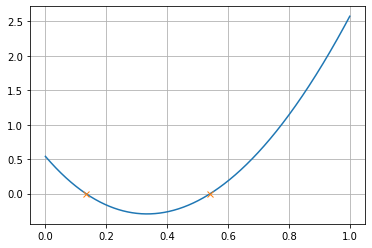

x0: 0.13314516090719167
x1: 0.5409807465428165


In [97]:
def f(x):
  return np.cos(1+x**2)*np.exp(-4*x)+4*(x**2-x)+(x-1)+np.cos(x)*x**2*np.exp(x/12)+x**3+1;

x0 = newtonRaphson(f,x0=0);
x1 = newtonRaphson(f,x0=1);
x = np.arange(0,1,0.001);
y = f(x);
plt.plot(x,y);
plt.plot([x0,x1],[0,0], "x", linewidth=2.0);
plt.grid(True);
plt.show();
print("x0:", x0);
print("x1:", x1);

**GMRES**
Generalized minimum residual method is an iterative method for finding the solution to systems of equations, more general than other methods. It works in ths rylov subspace that grows for each iteration, which means that it is more efficient in the beginning of the iterations than the end. This can be remedied by restarting the iterations with the current solution as the initial guess. This is not implemented here.

In [0]:
def arnoldi(A,b,k):

  m = A.shape[0];
  n = A.shape[1];
  Q = np.zeros((m,k+1));
  H = np.zeros((k+1,k));

  Q[:,0] = b/np.linalg.norm(b);
  for i in range(k):
    v = A @ Q[:,i];

    for j in range(i+1):
      H[j,i] = np.dot(Q[:,j], v);
      v -= H[j,i]*Q[:,j];

    H[i+1,i] = np.linalg.norm(v);
    Q[:,i+1] = v / H[i+1,i];

  return Q,H;

def stdBasis(k):
  b = np.zeros(k);
  b[0]=1;
  return b;

def gmres(A,b, tolerance=10**(-8)):
  b_norm = np.linalg.norm(b);
  r = b;

  k=1;
  while(np.linalg.norm(r)/b_norm > tolerance):
    Q,H = arnoldi(A,b,k);

    y = np.linalg.lstsq(H, b_norm*stdBasis(k+1), rcond=None)[0];
    r = H@y;
    r = b_norm*stdBasis(k+1)-r;
    k += 1;


  return Q[:,0:k-1] @ y, k;


In [143]:
n = np.random.randint(2,20);
A = np.random.rand(n,n);
x = np.random.rand(n);
b = A@x;

y,k = gmres(A,b);
print("#iterations:", k);
print(np.allclose(x,y));

#iterations: 12
True


**Newtons method for systems**
Like Newtons method for scalar functions, Newtons method for systems solves the vector valued function $\vec{f}(\mathbf{x})=\mathbf{0}$. The method reduces to the scalar version for vectors of length 1. It works by calculating the Jacobi matrix and then solving the equation $J\times \mathbf{dx} = \vec{f}(\mathbf{x})$, then updating its current guess by $\mathbf{x}_{n+1}=\mathbf{x}_{n}-\mathbf{dx}$.



In [0]:
def grad(f, x, delta=10**(-6)):
  d = np.zeros(len(x));
  for i in range(len(x)):
    dx = np.zeros(len(x));
    dx[i] += delta/2;
    d[i] = (f(x+dx)-f(x-dx))/delta;

  return d;

def jacobi(f, x, delta=10**(-6)):
  n = len(x);
  J = np.zeros((n,n));
  for i in range(n):
    J[i,:] = grad(f[i], x, delta=delta);

  return J;

def newtonVector(f, x0=0, tolerance=10**(-10), max_iter=100):
  if(x0==0):
    x = np.zeros(len(f)-1);
  else:
    assert len(f)-1 == len(x0);
    x = x0;

  i=0;
  while (np.linalg.norm(f[0](x)) > tolerance):
    J = jacobi(f[1:],x);  ## f[0] is vector function, f[1:] is f1,f2...
    dx,k = gmres(J, f[0](x));
    x -= dx;

    i+=1;
    if(i> max_iter):
      raise ArithmeticError("Function does not converge");

  return x;

In [124]:
def f1(x):
  return 1-x[0] + np.cos(x[2]) - np.sin(x[1]*np.exp(1/(1-x[0])));

def f2(x):
  return 2-x[0]-x[1] + np.sin(x[0]-x[1]);

def f3(x):
  return x[2]+(x[0]+x[1])**2 + np.sin(x[0]*x[1]-x[2])**2;

#def f4(x):
#  return -f1(x[::-1]);

#def f5(x):
# ...

def fn(x):
  return [f1(x), f2(x), f3(x)];

## 
f = (fn, f1, f2, f3);
print(fn([0,0,0]));

x0 = newtonVector(f);
print("x0:", x0);
print("f(x0):", fn(x0));

[2.0, 2.0, 0.0]
x0: [ 0.65465289  1.00351677 -2.95461194]
f(x0): [-3.885780586188048e-15, -5.551115123125783e-17, -5.551115123125783e-16]


# **Results**

In [144]:
class TestMatrixMethods(unittest.TestCase):

  def test_jacobiGauss(self):
    for i in range(1000):
      n = np.random.randint(2,10);
      A = np.random.rand(n,n);
      A = (A.transpose()+A)/2;
      ## Make sure A has spectral radius < 1 (otherwise methods don't converge)
      A += np.diag(np.diag(np.random.rand(n,n)+1)*20);
      A /= (np.max(np.abs(np.linalg.eig(A)[0])) +1);

      x = np.random.rand(n);
      b = A@x;

      self.assertTrue(np.linalg.norm(jacobiIter(A,b)-x) < 10**(-8));
      self.assertTrue(np.linalg.norm(A@jacobiIter(A,b)-b) < 10**(-8));

      self.assertTrue(np.linalg.norm(gaussSeidel(A,b)-x) < 10**(-8));
      self.assertTrue(np.linalg.norm(A@gaussSeidel(A,b)-b) < 10**(-8));

      self.assertTrue(np.allclose(x,jacobiIter(A,b)));
      self.assertTrue(np.allclose(x,gaussSeidel(A,b)));

  def test_gmres(self):
    for i in range(1000):
      n = np.random.randint(2,10);
      A = np.random.rand(n,n);
      x = np.random.rand(n);
      b = A@x;

      y,k = gmres(A,b);
      self.assertTrue(np.linalg.norm(x-y) < 10**(-8));
      self.assertTrue(np.linalg.norm(A@y - b) < 10**(-8));

  def test_newtonsmethod(self):
    pass
    ## How do you generate random functions and still knowing they have
    ## some roots? This would be more work than actually implementing 
    ## the functions

unittest.main(argv=[''], verbosity=2, exit=False);

test_gmres (__main__.TestMatrixMethods) ... /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
ok
test_jacobiGauss (__main__.TestMatrixMethods) ... ok
test_newtonsmethod (__main__.TestMatrixMethods) ... ok

----------------------------------------------------------------------
Ran 3 tests in 3.019s

OK


Testing these functions proved to be more of a difficult task than before, due to the need to generate random functions that is guarranteed to have roots. Instead of writing up an entire class for this, the methods where tested manually by writing a semi-random function and rewriting to test different functions. Therefore no automated test of this is included. I, the author, argues that the implementations of Newtons method works as intended, and any reader is encuraged to test it for themselves.

# **Discussion**

The implementations of the Jacobi and Gauss-Seidel iterations works as intended for matrices that have a spectral radius < 1. The generation of these are somewhat arbitrary, and there might be other ways of doing this that is not tested in this report. For the inputs as they are generated, the methods work as intended.

The implementations of GMRes works for any input, as long as a solution actually exists.

The implementations of Newtons method also seems to work, but they are more involved towrite tests for. However they do work as intended.